# PSI - Population Stability Index
Vinícius Trevisan 2022

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Data prep
from sklearn.model_selection import train_test_split

In [3]:
# Regression
from sklearn.linear_model import ElasticNet

In [4]:
def evaluate_regression(y, y_pred):
    
    '''
    Prints the most common evaluation metrics for regression
    '''
    
    mae = MAE(y, y_pred)
    mse = MSE(y, y_pred)
    rmse = mse ** (1/2)
    r2 = R2(y, y_pred)
    
    print('Regression result')
    print(f"MAE:  {mae:.4f}")
    print(f"MSE:  {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2:   {r2:.4f}")

In [5]:
def evaluate_classification(y, y_proba, threshold = 0.5):
    
    '''
    Prints the most common evaluation metrics for regression
    '''
    y_pred = [1 if y > threshold else 0 for y in y_proba]
    
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    roc_auc = roc_auc_score(y, y_proba)
    
    print('Classification result')
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1:        {f1:.4f}")
    print(f"ROC AUC:   {roc_auc:.4f}")

## Regressor

I will train a regressor with a synthetic dataset in a manner that:

$$y = a_1 \cdot x_1 + a_2 \cdot x_2 + a_3 \cdot x_3 + b$$

The features $x_1$, $x_2$ and $x_3$ will be sampled from different distributions and $y$ will be calculated for the train and test sets.

Then, I will create new features $z_1$, $z_2$ and $z_3$ which are the same features as before, but sampled with a slight deviation on $x_2$ to create $z_2$ and a large deviation on $x_3$ to create $z_3$. The feature $z_1$ will come from exactly the same distribution as $x_1$.

### Create Synthetic Dataset

In [6]:
# Sample size 
size = 5000

In [7]:
# Create random samples
x1 = np.random.normal(loc = 0, scale = 2, size = size)
x2 = np.random.normal(loc = 3, scale = 1, size = size)
x3 = np.random.normal(loc = 5, scale = 2, size = size)

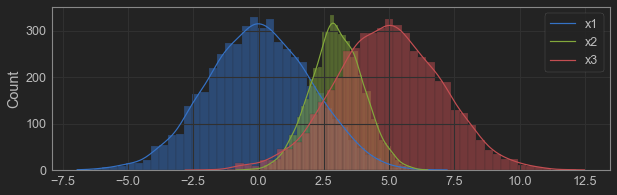

In [8]:
# Visualize them
plt.figure(figsize = (10,3))
sns.histplot(x1, kde = True, color = 'b')
sns.histplot(x2, kde = True, color = 'g')
sns.histplot(x3, kde = True, color = 'r')
plt.legend(["x1", "x2", "x3"])

In [9]:
# Create random samples
z1 = np.random.normal(loc = 0, scale = 2, size = size)  # The same as x1
z2 = np.random.normal(loc = 3.5, scale = 0.75, size = size)  # x2 with slight changes on scale and loc
z3 = np.random.normal(loc = 8, scale = 3, size = size)  # x3 with large changes on scale and loc

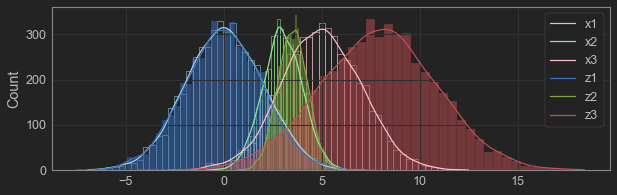

In [10]:
# Visualize them
plt.figure(figsize = (10,3))
sns.histplot(x1, kde = True, color = 'lightblue', fill = False)
sns.histplot(x2, kde = True, color = 'lightgreen', fill = False)
sns.histplot(x3, kde = True, color = 'pink', fill = False)
sns.histplot(z1, kde = True, color = 'b')
sns.histplot(z2, kde = True, color = 'g')
sns.histplot(z3, kde = True, color = 'r')
plt.legend(["x1", "x2", "x3", "z1", "z2", "z3"])

### Prepare train and test data

In [11]:
# yes, a2 = pi, a3 = e and b = phi
y = [-2*x1 + 3.1415*x2 + 2.7183*x3 + 1.6180 for (x1, x2, x3) in zip(x1,x2,x3)]

<AxesSubplot:>

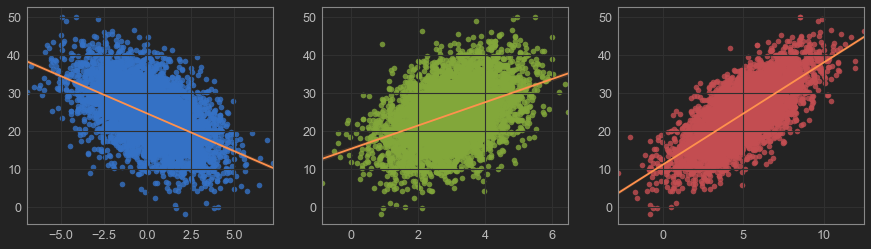

In [12]:
plt.figure(figsize = (15,4))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax3 = plt.subplot(1, 3, 3)
sns.regplot(x = x1, y = y, ax = ax1, scatter_kws={"color": "b"}, line_kws={"color": "y"})
sns.regplot(x = x2, y = y, ax = ax2, scatter_kws={"color": "g"}, line_kws={"color": "y"})
sns.regplot(x = x3, y = y, ax = ax3, scatter_kws={"color": "r"}, line_kws={"color": "y"})

In [13]:
df = pd.DataFrame({'x1': x1, 'x2': x2, 'x3': x3, 'y' : y})
X = df.drop(columns = 'y')
y = df['y']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

### Train the regressor

In [15]:
model = ElasticNet()

In [16]:
model.fit(X_train, y_train)

ElasticNet()

In [17]:
y_pred = model.predict(X_test)

### Predicts the shifted data

In [18]:
Z = pd.DataFrame({'x1': z1, 'x2': z2, 'x3': z3})

In [19]:
z_pred = model.predict(Z)

<AxesSubplot:>

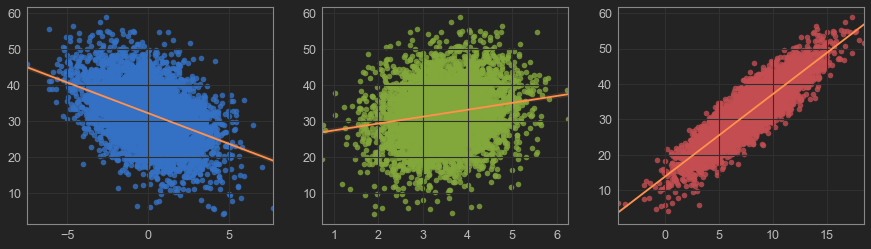

In [20]:
plt.figure(figsize = (15,4))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax3 = plt.subplot(1, 3, 3)
sns.regplot(x = z1, y = z_pred, ax = ax1, scatter_kws={"color": "b"}, line_kws={"color": "y"})
sns.regplot(x = z2, y = z_pred, ax = ax2, scatter_kws={"color": "g"}, line_kws={"color": "y"})
sns.regplot(x = z3, y = z_pred, ax = ax3, scatter_kws={"color": "r"}, line_kws={"color": "y"})

### Calculates the PSI - Fixed

In [21]:
score_initial = y_pred
score_new = z_pred
num_bins = 10
eps = 1e-4

In [22]:
# Sorts the data
score_initial.sort()
score_new.sort()

In [23]:
# Prepare the bins
min_val = min(min(score_initial), min(score_new))
max_val = max(max(score_initial), max(score_new))
bins = [min_val + (max_val - min_val)*(i)/num_bins for i in range(num_bins+1)]
bins[0] = min_val - eps # Corrects the lower boundary
bins[-1] = max_val + eps # Corrects the higher boundary

In [24]:
# Bucketize the initial population and count the sample inside each bucket
bins_initial = pd.cut(score_initial, bins = bins, labels = range(1,num_bins+1))
df_initial = pd.DataFrame({'initial': score_initial, 'bin': bins_initial})
grp_initial = df_initial.groupby('bin').count()
grp_initial['percent_initial'] = grp_initial['initial'] / sum(grp_initial['initial'])

In [25]:
grp_initial

,initial,percent_initial
bin,,
1,3,0.003
2,52,0.052
3,188,0.188
4,351,0.351
5,289,0.289
6,103,0.103
7,14,0.014
8,0,0.000
9,0,0.000


In [26]:
# Bucketize the new population and count the sample inside each bucket
bins_new = pd.cut(score_new, bins = bins, labels = range(1,num_bins+1))
df_new = pd.DataFrame({'new': score_new, 'bin': bins_new})
grp_new = df_new.groupby('bin').count()
grp_new['percent_new'] = grp_new['new'] / sum(grp_new['new'])

In [27]:
grp_new

,new,percent_new
bin,,
1,13,0.0026
2,57,0.0114
3,276,0.0552
4,707,0.1414
5,1187,0.2374
6,1410,0.2820
7,883,0.1766
8,362,0.0724
9,85,0.0170


In [28]:
# Compares the bins to calculate PSI
psi_df = grp_initial.join(grp_new, on = "bin", how = "inner")

In [29]:
psi_df

,initial,percent_initial,new,percent_new
bin,,,,
1,3,0.003,13,0.0026
2,52,0.052,57,0.0114
3,188,0.188,276,0.0552
4,351,0.351,707,0.1414
5,289,0.289,1187,0.2374
6,103,0.103,1410,0.2820
7,14,0.014,883,0.1766
8,0,0.000,362,0.0724
9,0,0.000,85,0.0170


In [30]:
# Adds a small value for when the percent is zero
psi_df['percent_initial'] = psi_df['percent_initial'].apply(lambda x: eps if x == 0 else x)
psi_df['percent_new'] = psi_df['percent_new'].apply(lambda x: eps if x == 0 else x)

In [31]:
# Calculates the psi
psi_df['psi'] = (psi_df['percent_initial'] - psi_df['percent_new']) * np.log(psi_df['percent_initial'] / psi_df['percent_new'])

In [32]:
psi_df

,initial,percent_initial,new,percent_new,psi
bin,,,,,
1,3,0.0030,13,0.0026,0.000057
2,52,0.0520,57,0.0114,0.061616
3,188,0.1880,276,0.0552,0.162744
4,351,0.3510,707,0.1414,0.190567
5,289,0.2890,1187,0.2374,0.010149
6,103,0.1030,1410,0.2820,0.180285
7,14,0.0140,883,0.1766,0.412163
8,0,0.0001,362,0.0724,0.476080
9,0,0.0001,85,0.0170,0.086795


In [33]:
psi_plot = psi_df.reset_index()
psi_plot = pd.melt(psi_plot[['bin', 'percent_initial', 'percent_new']], id_vars = 'bin', var_name = 'set', value_name = 'percent')

<AxesSubplot:xlabel='bin', ylabel='percent'>

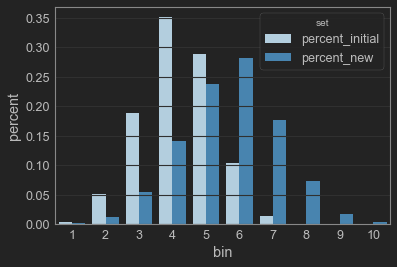

In [34]:
sns.barplot(x = 'bin', y = 'percent', hue = 'set', data = psi_plot, palette = 'Blues')

In [35]:
psi_values = psi_df['psi'].values

In [36]:
psi_values

array([5.72403375e-05, 6.16157927e-02, 1.62743612e-01, 1.90566951e-01,
       1.01486986e-02, 1.80284877e-01, 4.12163351e-01, 4.76080418e-01,
       8.67949936e-02, 1.43866299e-02])

In [37]:
np.mean(psi_values)

0.15948425646819625

### Calculates the PSI - Fixed

In [38]:
score_initial = y_pred
score_new = z_pred
num_bins = 10
eps = 1e-4

In [39]:
# Sorts the data
score_initial.sort()
score_new.sort()

In [40]:
# Prepare the bins
min_val = min(min(score_initial), min(score_new))
max_val = max(max(score_initial), max(score_new))
bins = pd.qcut(score_initial, q = num_bins, retbins = True)[1]
bins[0] = min_val - eps # Corrects the lower boundary
bins[-1] = max_val + eps # Corrects the higher boundary

In [41]:
# Bucketize the initial population and count the sample inside each bucket
bins_initial = pd.cut(score_initial, bins = bins, labels = range(1,num_bins+1))
df_initial = pd.DataFrame({'initial': score_initial, 'bin': bins_initial})
grp_initial = df_initial.groupby('bin').count()
grp_initial['percent_initial'] = grp_initial['initial'] / sum(grp_initial['initial'])

In [42]:
grp_initial

,initial,percent_initial
bin,,
1,100,0.1
2,100,0.1
3,100,0.1
4,100,0.1
5,100,0.1
6,100,0.1
7,100,0.1
8,100,0.1
9,100,0.1


In [43]:
# Bucketize the new population and count the sample inside each bucket
bins_new = pd.cut(score_new, bins = bins, labels = range(1,num_bins+1))
df_new = pd.DataFrame({'new': score_new, 'bin': bins_new})
grp_new = df_new.groupby('bin').count()
grp_new['percent_new'] = grp_new['new'] / sum(grp_new['new'])

In [44]:
grp_new

,new,percent_new
bin,,
1,137,0.0274
2,144,0.0288
3,164,0.0328
4,173,0.0346
5,194,0.0388
6,256,0.0512
7,334,0.0668
8,427,0.0854
9,569,0.1138


In [45]:
# Compares the bins to calculate PSI
psi_df = grp_initial.join(grp_new, on = "bin", how = "inner")

In [46]:
psi_df

,initial,percent_initial,new,percent_new
bin,,,,
1,100,0.1,137,0.0274
2,100,0.1,144,0.0288
3,100,0.1,164,0.0328
4,100,0.1,173,0.0346
5,100,0.1,194,0.0388
6,100,0.1,256,0.0512
7,100,0.1,334,0.0668
8,100,0.1,427,0.0854
9,100,0.1,569,0.1138


In [47]:
# Adds a small value for when the percent is zero
psi_df['percent_initial'] = psi_df['percent_initial'].apply(lambda x: eps if x == 0 else x)
psi_df['percent_new'] = psi_df['percent_new'].apply(lambda x: eps if x == 0 else x)

In [48]:
# Calculates the psi
psi_df['psi'] = (psi_df['percent_initial'] - psi_df['percent_new']) * np.log(psi_df['percent_initial'] / psi_df['percent_new'])

In [49]:
psi_df

,initial,percent_initial,new,percent_new,psi
bin,,,,,
1,100,0.1,137,0.0274,0.093990
2,100,0.1,144,0.0288,0.088629
3,100,0.1,164,0.0328,0.074911
4,100,0.1,173,0.0346,0.069410
5,100,0.1,194,0.0388,0.057941
6,100,0.1,256,0.0512,0.032668
7,100,0.1,334,0.0668,0.013395
8,100,0.1,427,0.0854,0.002304
9,100,0.1,569,0.1138,0.001784


In [50]:
psi_plot = psi_df.reset_index()
psi_plot = pd.melt(psi_plot[['bin', 'percent_initial', 'percent_new']], id_vars = 'bin', var_name = 'set', value_name = 'percent')

<AxesSubplot:xlabel='bin', ylabel='percent'>

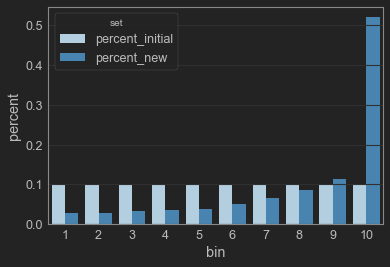

In [51]:
sns.barplot(x = 'bin', y = 'percent', hue = 'set', data = psi_plot, palette = 'Blues')

In [52]:
psi_values = psi_df['psi'].values

In [53]:
psi_values

array([0.09398993, 0.08862939, 0.07491064, 0.0694101 , 0.0579411 ,
       0.03266822, 0.01339511, 0.00230423, 0.00178396, 0.69341935])

In [54]:
np.mean(psi_values)

0.11284520185048848